# Outubro rosa e ciência de dados: prevendo câncer de mama através de algoritmos de Machine Learning 

Primeiro importamos as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score

In [ ]:
!pip install pycaret -q

In [ ]:
from pycaret.classification import *

Agora importaremos o conjunto de dados e veremos suas informações:

In [5]:
data_path = 'breast-cancer-wisconsin.csv'
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Usamos o método head() para exibir as 5 primeiras linhas do nosso dataframe

In [5]:
df.head()

id diagnosis  ...  fractal_dimension_worst  Unnamed: 32
0    842302         M  ...                  0.11890          NaN
1    842517         M  ...                  0.08902          NaN
2  84300903         M  ...                  0.08758          NaN
3  84348301         M  ...                  0.17300          NaN
4  84358402         M  ...                  0.07678          NaN

[5 rows x 33 columns]

## Dicionário de variáveis

---
Essas variáveis dizem respeito ao núcleo do tumor


**Diagnosis:** Diagnóstico se é um tumor maligno (**M**) ou benigno (**B**)

**Radius:** Média da distância do centro até os pontos do contorno

**Texture:** A textura do núcleo da célula é medida pelo desvio padrão da intensidade da escala de cinza nos pixels componentes

**Perimeter:** Perímetro do núcleo da célula

**Area:** Área da superfície do núcleo da célula

**Smoothness:** A diferença entre o tamanho da linha do raio e a média das linhas ao redor do núcleo do tumor. Ou também a Variação local no comprimento de raio.

**Compactness:** O perímetro e a área são combinados para dar uma medida *compactness* dos núcleos das células usando a fórmula **perímetro^2 / área**.

**Concavity:** Mede a magnitude das concavidades do contorno

**Concave points:** Número de porções côncavas do contorno

**Symmetry:** Para medir a simetria, o eixo principal, ou corda mais longa através do centro, é encontrado. Em seguida, medimos a diferença de comprimento entre as linhas perpendiculares ao eixo principal até o limite nuclear em ambas as direções. 

**Fractal_dimension:** Traçar o log do perímetro observado contra o log do tamanho da régua e medir a inclinação descendente para encontrar uma aproximação da dimensão fractal.



Temos aí uma coluna inteira com valores nulos, e uma coluna que representa a identificação do paciente. Excluiremos essas colunas.

In [6]:
df = df.drop(['Unnamed: 32', 'id'], axis=1)

Temos também atributos de três tipos: "mean", "se" e "worst". Utilizaremos, aqui, apenas a "mean", pois essa nos dá a média de cada atributo.

In [7]:
df.columns
df = df.drop(columns=['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'])

In [8]:
df.head()

diagnosis  radius_mean  ...  symmetry_mean  fractal_dimension_mean
0         M        17.99  ...         0.2419                 0.07871
1         M        20.57  ...         0.1812                 0.05667
2         M        19.69  ...         0.2069                 0.05999
3         M        11.42  ...         0.2597                 0.09744
4         M        20.29  ...         0.1809                 0.05883

[5 rows x 11 columns]

In [9]:
df.describe()

radius_mean  texture_mean  ...  symmetry_mean  fractal_dimension_mean
count   569.000000    569.000000  ...     569.000000              569.000000
mean     14.127292     19.289649  ...       0.181162                0.062798
std       3.524049      4.301036  ...       0.027414                0.007060
min       6.981000      9.710000  ...       0.106000                0.049960
25%      11.700000     16.170000  ...       0.161900                0.057700
50%      13.370000     18.840000  ...       0.179200                0.061540
75%      15.780000     21.800000  ...       0.195700                0.066120
max      28.110000     39.280000  ...       0.304000                0.097440

[8 rows x 10 columns]

In [10]:
display(df.min())
display(df.max())

diagnosis                       B
radius_mean                 6.981
texture_mean                 9.71
perimeter_mean              43.79
area_mean                   143.5
smoothness_mean           0.05263
compactness_mean          0.01938
concavity_mean                  0
concave points_mean             0
symmetry_mean               0.106
fractal_dimension_mean    0.04996
dtype: object

diagnosis                       M
radius_mean                 28.11
texture_mean                39.28
perimeter_mean              188.5
area_mean                    2501
smoothness_mean            0.1634
compactness_mean           0.3454
concavity_mean             0.4268
concave points_mean        0.2012
symmetry_mean               0.304
fractal_dimension_mean    0.09744
dtype: object

## Análise Exploratória de Dados (AED)

---
Fazer uma boa AED nos ajuda a entender como estão distribuídas e organizadas nossas variáveis/atributos, utilizando estatística descritiva e plotagens de gráficos exploraremos nossos dados.

Nessa fase do projeto estudaremos as distribuições de cada atributo, começando pelo diagnóstico.


Diagnóstico (maligno x benigno)

---

Veremos agora a quantidade de tumores malignos X beningnos no nosso dataframe.

In [ ]:
M = df.diagnosis.value_counts()[1]
B = df.diagnosis.value_counts()[0]
TOTAL = B + M
print(f'Maligno: {M}\nBenigno: {B}\nMaligno(%): {M/TOTAL:.2f}%\nBenigno(%): {B/TOTAL:.2f}%')

Maligno: 212
Benigno: 357
Maligno(%): 0.37%
Benigno(%): 0.63%


Plotando em um gráfico:

In [12]:
plt.figure(figsize=(10,5))
sns.countplot('diagnosis', data=df);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Agora plotaremos gráficos de distribuição para os diagnósticos malignos e para os benignos

* Média da área

Mediana da área média para tumores benignos: 458.4
Mediana da área média para tumores malignos: 932.0


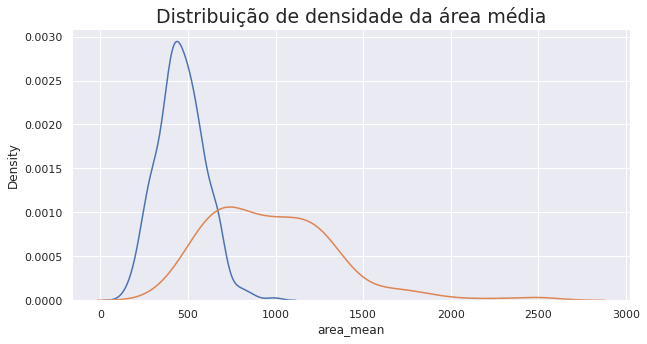

In [16]:
import seaborn as sns
B_area = df[df['diagnosis']=='B']['area_mean'].median()
M_area = df[df['diagnosis']=='M']['area_mean'].median()
print(f'Mediana da área média para tumores benignos: {B_area}')
print(f'Mediana da área média para tumores malignos: {M_area}')

plt.figure(figsize=(10,5))
sns.kdeplot(df[df['diagnosis']=='B']['area_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['area_mean'])
plt.title('Distribuição de densidade da área média',fontsize=19);

In [77]:
df['area_mean'].max()

2501.0

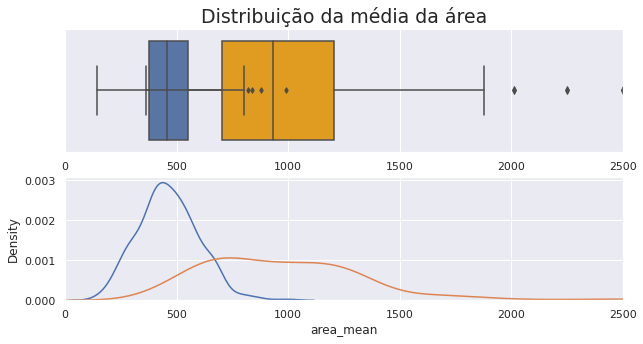

In [102]:
fig1 = plt.figure(figsize=(10,5))

plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['area_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['area_mean'])
plt.title(' ')
plt.xlim(0,2501)

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['area_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['area_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média da área',fontsize=19)
plt.xlim(0,2501)
plt.xlabel(' ');

* Média "compactness"

Mediana da compacidade média para tumores benignos: 0.07529
Mediana da compacidade média para tumores malignos: 0.13235


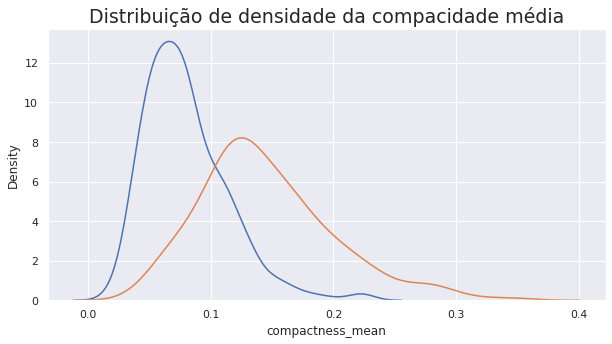

In [23]:
B_comp = df[df['diagnosis']=='B']['compactness_mean'].median()
M_comp = df[df['diagnosis']=='M']['compactness_mean'].median()
print(f'Mediana da compacidade média para tumores benignos: {B_comp}')
print(f'Mediana da compacidade média para tumores malignos: {M_comp}')

plt.figure(figsize=(10,5))
sns.kdeplot(df[df['diagnosis']=='B']['compactness_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['compactness_mean'])
plt.title('Distribuição de densidade da compacidade média', fontsize=19);

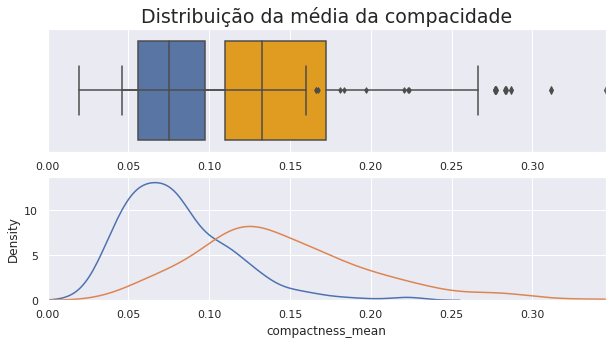

In [103]:
fig1 = plt.figure(figsize=(10,5))

plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['compactness_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['compactness_mean'])
plt.title(' ')
plt.xlim(0,0.3454)

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['compactness_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['compactness_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média da compacidade',fontsize=19)
plt.xlim(0,0.3454)
plt.xlabel(' ');

In [63]:
df['compactness_mean'].max()

0.3454

* Média dos pontos côncavos

Mediana dos pontos côncavos médios para tumores benignos: 0.02344
Mediana dos pontos côncavos médios para tumores malignos: 0.08628


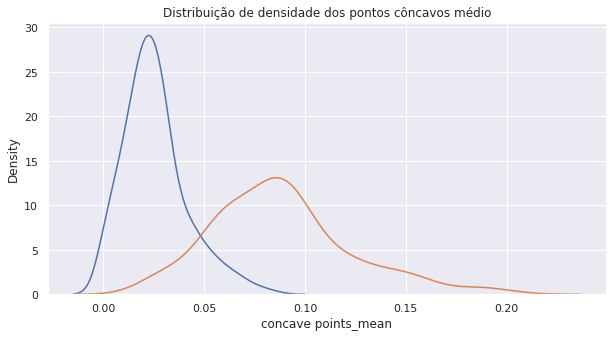

In [49]:
B_concp = df[df['diagnosis']=='B']['concave points_mean'].median()
M_concp = df[df['diagnosis']=='M']['concave points_mean'].median()
print(f'Mediana dos pontos côncavos para tumores benignos: {B_concp}')
print(f'Mediana dos pontos côncavos para tumores malignos: {M_concp}')

plt.figure(figsize=(10,5))
sns.kdeplot(df[df['diagnosis']=='B']['concave points_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['concave points_mean'])
plt.title('Distribuição de densidade dos pontos côncavos médio');

In [70]:
fig1 = plt.figure(figsize=(10,5))

plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['concave points_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['concave points_mean'])
plt.title(' ')
plt.xlim(0,0.200)

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['concave points_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['concave points_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média dos pontos côncavos',fontsize=19)
plt.xlim(0,0.200)
plt.xlabel(' ');

* Média da concavidade

In [114]:
B_conc = df[df['diagnosis']=='B']['concavity_mean'].median()
M_conc = df[df['diagnosis']=='M']['concavity_mean'].median()
print(f'Mediana da concavidade média para tumores benignos: {B_conc}')
print(f'Mediana da concavidade média para tumores malignos: {M_conc:.5f}')

sns.kdeplot(df[df['diagnosis']=='B']['concavity_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['concavity_mean']);

Mediana da concavidade média para tumores benignos: 0.03709
Mediana da concavidade média para tumores malignos: 0.15135


In [84]:
df.concavity_mean.max()

0.4268

In [104]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['concavity_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['concavity_mean'])
plt.title(' ')
plt.xlim(0,df.concavity_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['concavity_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['concavity_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média da concavidade',fontsize=19)
plt.xlim(0,df.concavity_mean.max())
plt.xlabel(' ');

* Média da dimensão fractal

Mediana da dimensão fractal para tumores benignos: 0.06154
Mediana da dimensão fractal para tumores malignos: 0.061575


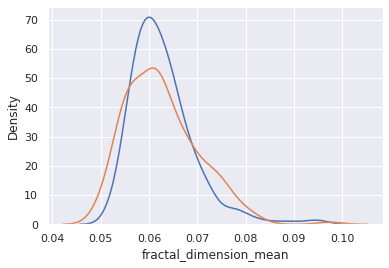

In [113]:
B_dimf = df[df['diagnosis']=='B']['fractal_dimension_mean'].median()
M_dimf = df[df['diagnosis']=='M']['fractal_dimension_mean'].median()
print(f'Mediana da dimensão fractal para tumores benignos: {B_dimf}')
print(f'Mediana da dimensão fractal para tumores malignos: {M_dimf}')

sns.kdeplot(df[df['diagnosis']=='B']['fractal_dimension_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['fractal_dimension_mean']);

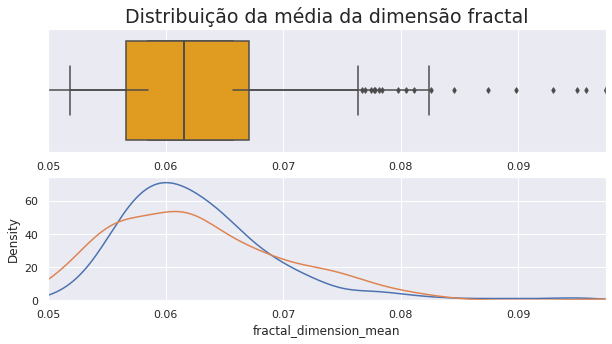

In [112]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['fractal_dimension_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['fractal_dimension_mean'])
plt.title(' ')
plt.xlim(df.fractal_dimension_mean.min(),df.fractal_dimension_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['fractal_dimension_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['fractal_dimension_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média da dimensão fractal',fontsize=19)
plt.xlim(df.fractal_dimension_mean.min(),df.fractal_dimension_mean.max())
plt.xlabel(' ');

* Média do perímetro 

Mediana do perímetro médio para tumores benignos: 78.18
Mediana do perímetro médio para tumores malignos: 114.2


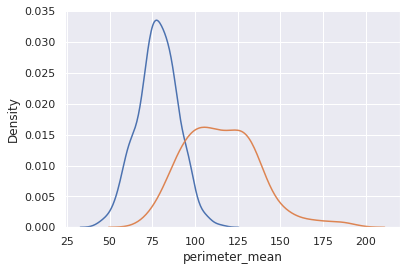

In [115]:
B_per = df[df['diagnosis']=='B']['perimeter_mean'].median()
M_per = df[df['diagnosis']=='M']['perimeter_mean'].median()
print(f'Mediana do perímetro médio para tumores benignos: {B_per}')
print(f'Mediana do perímetro médio para tumores malignos: {M_per}')

sns.kdeplot(df[df['diagnosis']=='B']['perimeter_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['perimeter_mean']);

In [91]:
df.perimeter_mean.max()

188.5

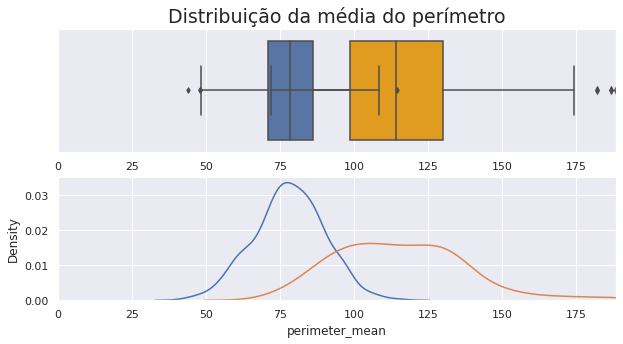

In [116]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['perimeter_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['perimeter_mean'])
plt.title(' ')
plt.xlim(0,188.5)

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['perimeter_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['perimeter_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média do perímetro',fontsize=19)
plt.xlim(0,188.5)
plt.xlabel(' ');

* Média do raio

Mediana do raio médio para tumores benignos: 12.2
Mediana do raio médio para tumores malignos: 17.3


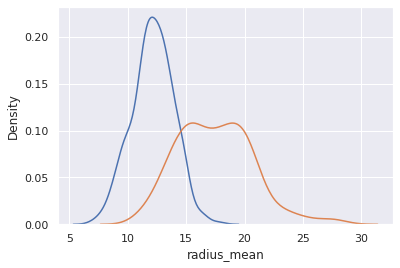

In [119]:
B_raio = df[df['diagnosis']=='B']['radius_mean'].median()
M_raio = df[df['diagnosis']=='M']['radius_mean'].median()
print(f'Mediana do raio médio para tumores benignos: {B_raio}')
print(f'Mediana do raio médio para tumores malignos: {M_raio:.1f}')

sns.kdeplot(df[df['diagnosis']=='B']['radius_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['radius_mean']);

In [94]:
df.radius_mean.max()

28.11

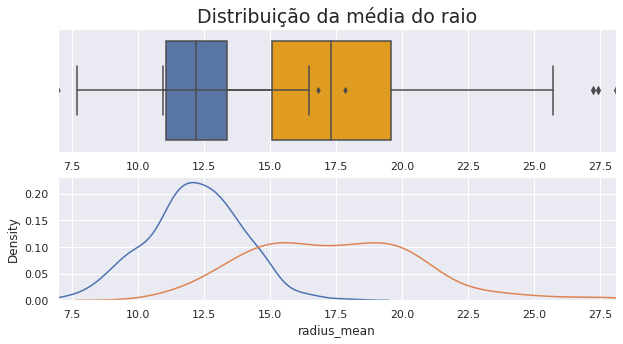

In [111]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['radius_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['radius_mean'])
plt.title(' ')
plt.xlim(df.radius_mean.min(),df.radius_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['radius_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['radius_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média do raio',fontsize=19)
plt.xlim(df.radius_mean.min(),df.radius_mean.max())
plt.xlabel(' ');

* Média "smoothness"

In [122]:
B_smot = df[df['diagnosis']=='B']['smoothness_mean'].median()
M_smot = df[df['diagnosis']=='M']['smoothness_mean'].median()
print(f'Mediana da suavidade média para tumores benignos: {B_smot:.4f}')
print(f'Mediana da suavidade média para tumores malignos: {M_smot}')

sns.kdeplot(df[df['diagnosis']=='B']['smoothness_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['smoothness_mean']);

Mediana da suavidade média para tumores benignos: 0.0908
Mediana da suavidade média para tumores malignos: 0.1022


In [98]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['smoothness_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['smoothness_mean'])
plt.title(' ')
plt.xlim(0,df.smoothness_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['smoothness_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['smoothness_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média de suavidade',fontsize=19)
plt.xlim(0,df.smoothness_mean.max())
plt.xlabel(' ');

* Simetria média

In [ ]:
B_sym = df[df['diagnosis']=='B']['symmetry_mean'].median()
M_sym = df[df['diagnosis']=='M']['symmetry_mean'].median()
print(f'Mediana da simetria média para tumores benignos: {B_sym}')
print(f'Mediana da simetria média para tumores malignos: {M_sym}')

sns.kdeplot(df[df['diagnosis']=='B']['symmetry_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['symmetry_mean']);

Mediana da simetria média para tumores benignos: 0.1714
Mediana da simetria média para tumores malignos: 0.1899


In [100]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['symmetry_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['symmetry_mean'])
plt.title(' ')
plt.xlim(0,df.symmetry_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['symmetry_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['symmetry_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média de simetria',fontsize=19)
plt.xlim(0,df.symmetry_mean.max())
plt.xlabel(' ');

* Média da textura

Mediana da textura média para tumores benignos: 17.39
Mediana da textura média para tumores malignos: 21.46


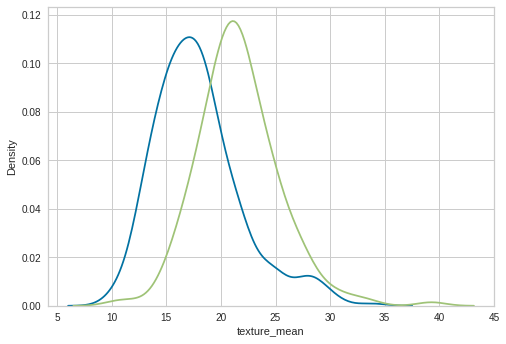

In [ ]:
B_text = df[df['diagnosis']=='B']['texture_mean'].median()
M_text = df[df['diagnosis']=='M']['texture_mean'].median()
print(f'Mediana da textura média para tumores benignos: {B_text}')
print(f'Mediana da textura média para tumores malignos: {M_text}')

sns.kdeplot(df[df['diagnosis']=='B']['texture_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['texture_mean']);

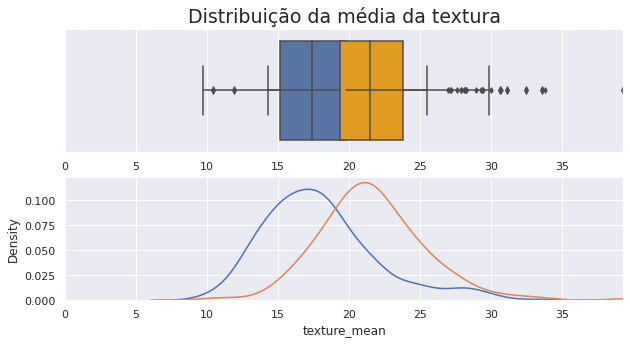

In [101]:
fig1 = plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
sns.kdeplot(df[df['diagnosis']=='B']['texture_mean'])
sns.kdeplot(df[df['diagnosis']=='M']['texture_mean'])
plt.title(' ')
plt.xlim(0,df.texture_mean.max())

plt.subplot(2,1,1)
sns.boxplot(x=df[df['diagnosis']=='B']['texture_mean'], fliersize=4)
sns.boxplot(x=df[df['diagnosis']=='M']['texture_mean'], color='orange', fliersize=5)
plt.title('Distribuição da média da textura',fontsize=19)
plt.xlim(0,df.texture_mean.max())
plt.xlabel(' ');

Agora plotaremos um gráfico de correlação do conjunto de dados, separados por "malignos" e "benignos". Esse gráfico irá correlacionar todos os atributos, para termos um panorama geral de coom estão separados e correlacionados, podendo encontrar padrões úteis para a modelagem.

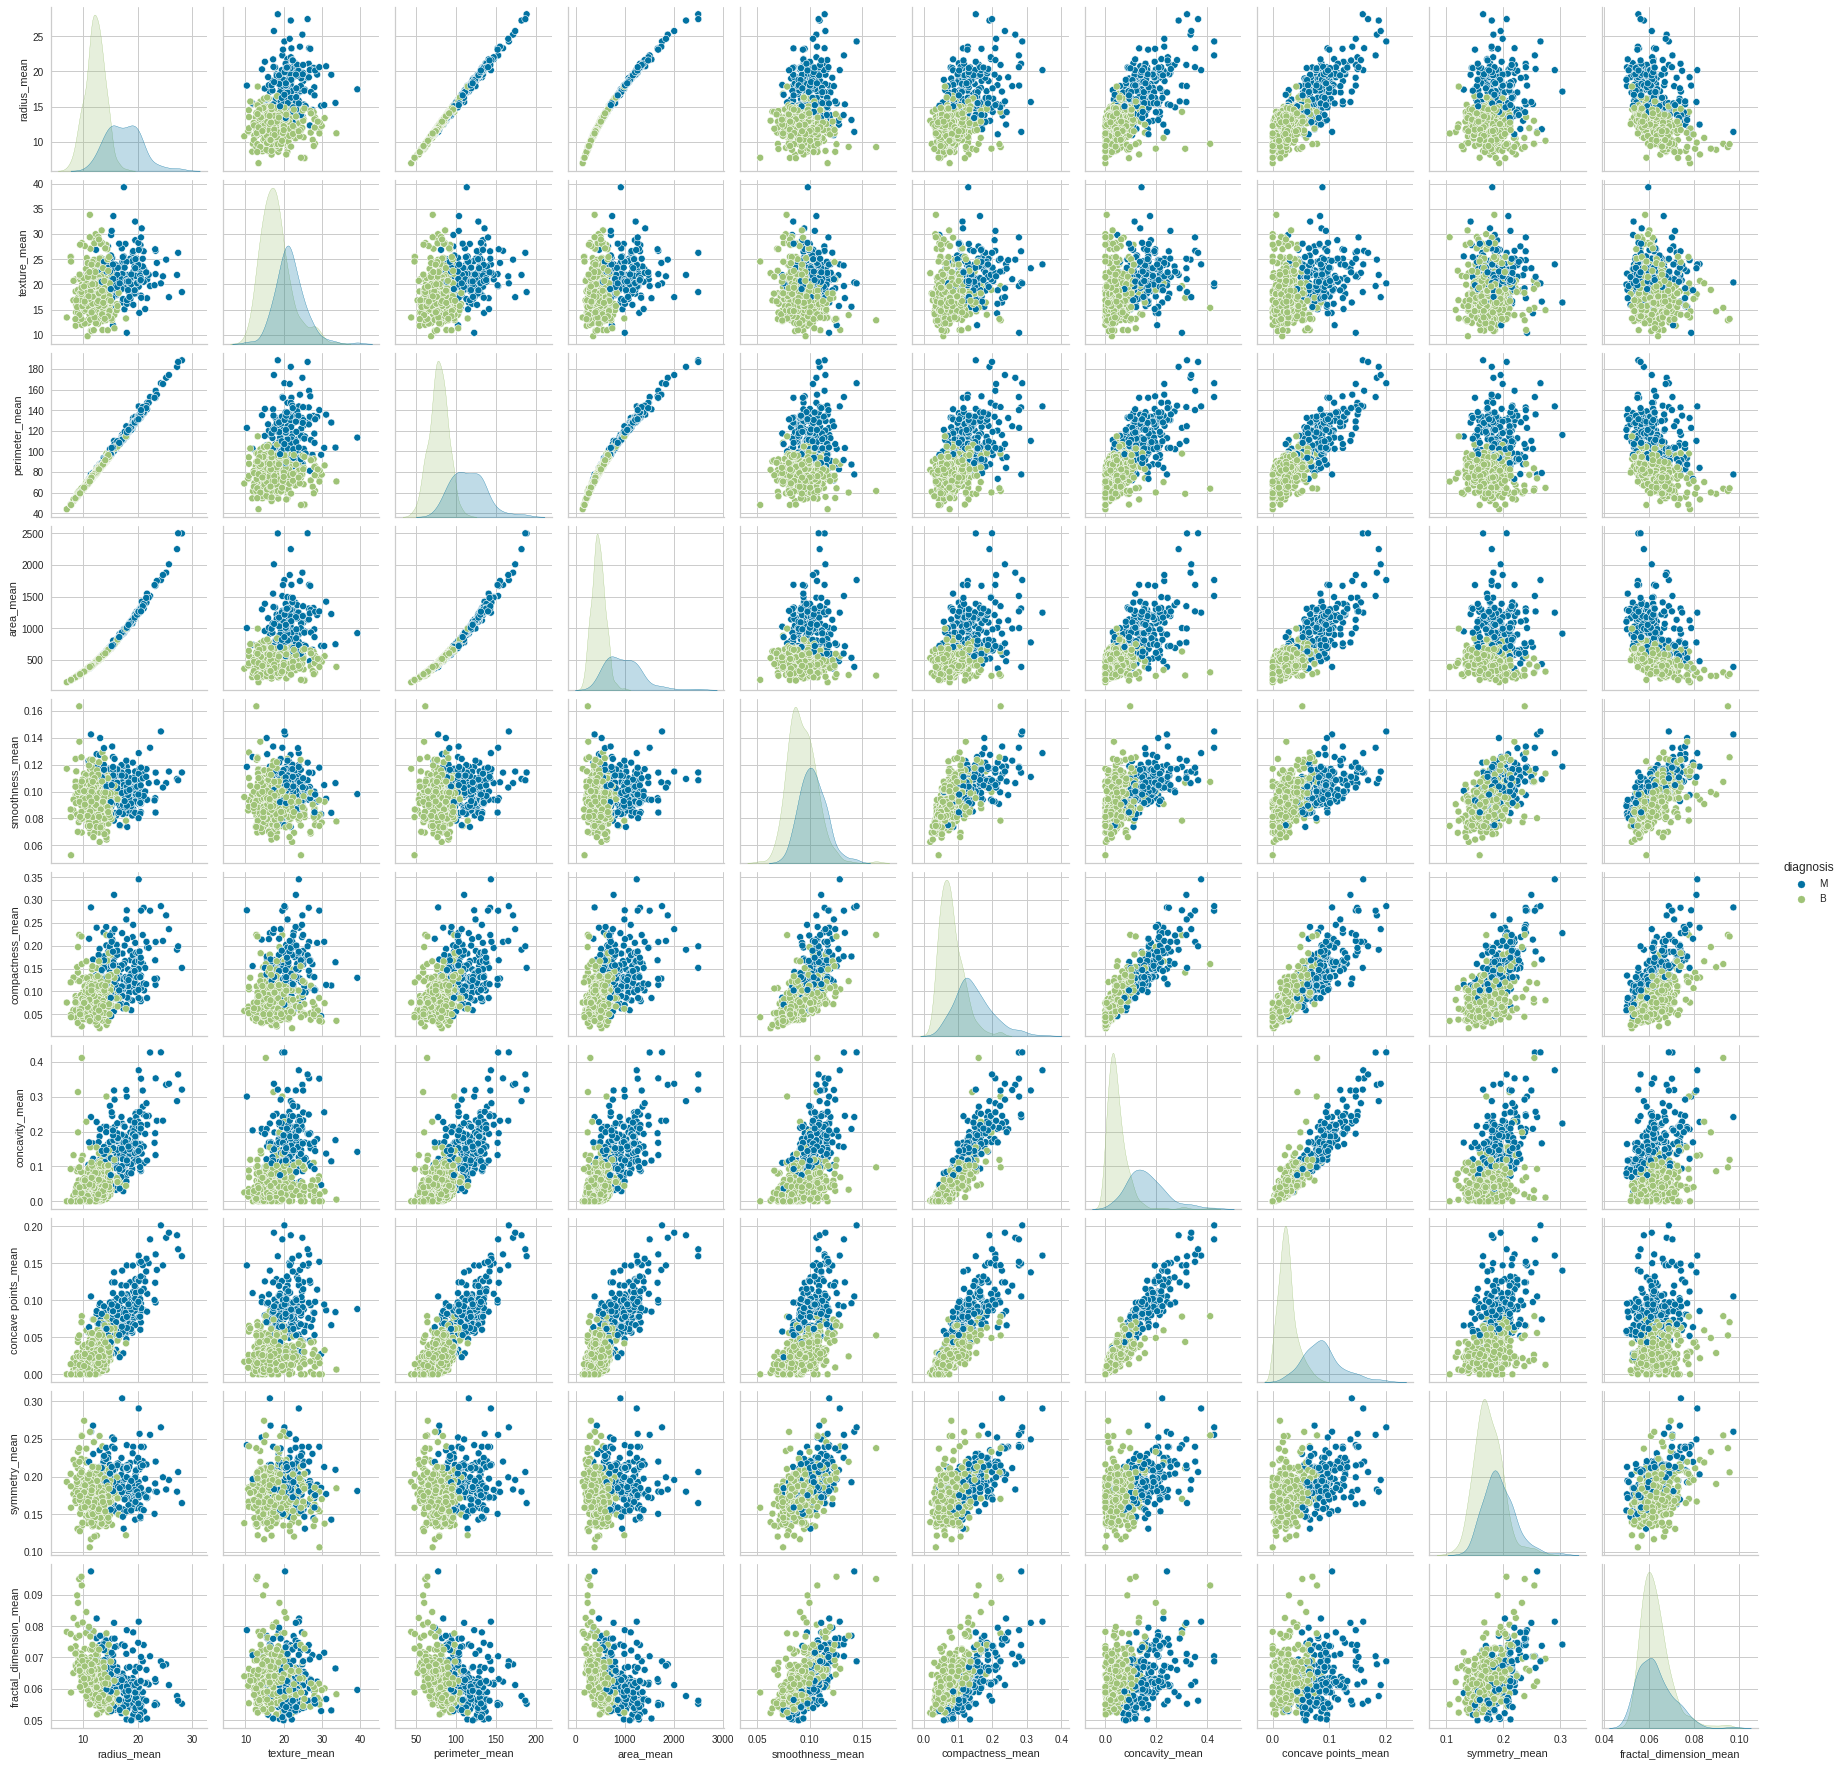

In [ ]:
sns.pairplot(df, hue='diagnosis');

## Construção do modelo usando PyCaret

---
Passada a etapa de análise exploratória, agora construiremos nosso modelo de Machine Learning.

Pycaret é uma biblioteca de auto - Machine Learning, capaz de construir e comparar diversos modelos de modo muito simples e rápido, fazendo com que possamos focar nas explicações acerca do assunto. E como é um tema bem importante e complexo de ser abordado, a melhor maneira de manter a produtividade é construindo modelos de modo mais rápido. Portanto, PyCaret é a escolha perfeita para o momento 


Primeiro construiremos nosso modelo, usando 80% dos dados como treino e 20% como teste (leia sobre [Princípio de Pareto](https://pt.wikipedia.org/wiki/Princ%C3%ADpio_de_Pareto))

In [ ]:
model = setup(df, target='diagnosis', train_size=0.8, fix_imbalance=True)

Setup Succesfully Completed!


Agora iremos comparar modelos para nossos dados

In [ ]:
modelos = compare_models()

Escolherei um modelo que não seja "boosting", pois algumas métricas não são visualizáveis pelo PyCaret. Logo, escolherei o algoritmo Random forest, pois a performance cai muito pouco, e podemos visualizar muitas métricas de validação.

Agora criaremos nosso modelo usando o PyCaret em uma única linha

In [ ]:
modelo_criado = create_model('rf')

## Métricas de avaliação

---
Durante o processo de criação de um modelo de machine learning nós precisamos medir a qualidade dele de acordo com o objetivo da tarefa. Existem funções matemáticas que nos ajudam a avaliar a capacidade de erro e acerto dos nossos modelos, e agora você conhecerá algumas das mais utilizadas. No artigo, usarei a palavra métrica para me referir a essas funções.

Tão importante quanto saber escolher um bom modelo, é saber escolher a métrica correta para decidir qual é o melhor entre eles.

Existem métricas mais simples, outras mais complexas, algumas que funcionam melhor para datasets com determinadas características, ou outras personalizadas de acordo com o objetivo final do modelo.

Ao escolher uma métrica deve-se levar em consideração fatores como a proporção de dados de cada classe no dataset e o objetivo da previsão (probabilidade, binário, ranking, etc). Por isso é importante conhecer bem a métrica que será utilizada, já que isso pode fazer a diferença na prática.

Nenhuma destas funções é melhor do que as outras em todos os casos. É sempre importante levar em consideração a aplicação prática do modelo. O objetivo deste artigo não é ir a fundo em cada uma delas, mas apresentá-las para que você possa pesquisar mais sobre as que achar interessante.


A curva **ROC** mostra o quão bom o modelo criado pode distinguir entre duas coisas (já que é utilizado para classificação). Essas duas coisas podem ser 0 ou 1, ou positivo e negativo. Os melhores modelos conseguem distinguir com precisão o binômio.

O valor do **AUC** varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe. Quanto maior o AUC, melhor.

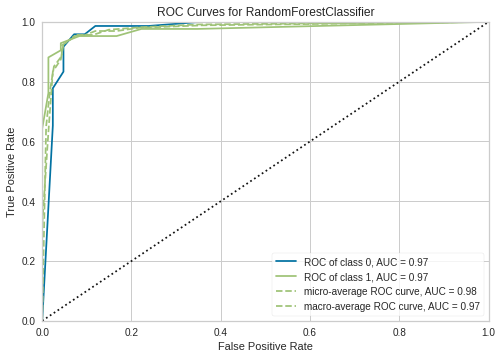

In [ ]:
plot_model(modelo_criado)

### Matriz de confusão

---
É um tabela que mostra as frequências de classificação para cada classe do modelo.

* **Verdadeiro positivo** (true positive — TP): ocorre quando no conjunto real, a classe que estamos buscando foi prevista corretamente. Por exemplo, quando a mulher está com câncer e o modelo previu corretamente que ela está câncer.

* **Falso positivo** (false positive — FP): ocorre quando no conjunto real, a classe que estamos buscando prever foi prevista incorretamente. Exemplo: a mulher não está com câncer, mas o modelo disse que ela está.

* **Falso verdadeiro** (true negative — TN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista corretamente. Exemplo: a mulher não estava com câncer, e o modelo previu corretamente que ela não está.

* **Falso negativo** (false negative — FN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista incorretamente. Por exemplo, quando a mulher está com câncer e o modelo previu incorretamente que ela não está com câncer.

[Sobre matriz de confusão](https:https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509#:~:text=%C3%89%20um%20tabela%20que%20mostra,estamos%20buscando%20foi%20prevista%20corretamente.//)

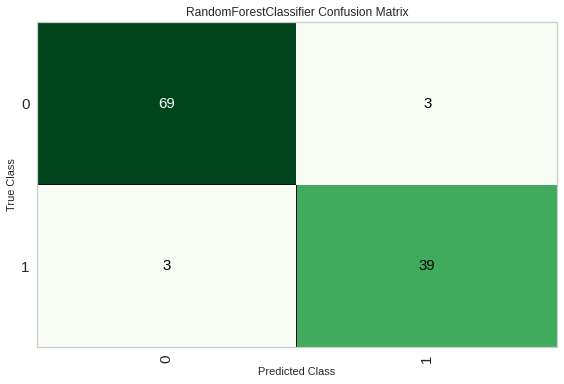

In [ ]:
plot_model(modelo_criado, plot='confusion_matrix')

## *Feature importance*

---
As pontuações relativas podem destacar quais características podem ser mais relevantes para o alvo e, ao contrário, quais características são menos relevantes. Isso pode ser interpretado por um especialista no domínio e pode ser usado como base para a coleta de mais ou diferentes dados.

 A maioria das pontuações de importância são calculadas por um modelo preditivo que foi ajustado ao conjunto de dados. A inspeção da pontuação de importância fornece uma visão sobre esse modelo específico e quais recursos são os mais e menos importantes para o modelo ao fazer uma previsão. Este é um tipo de interpretação de modelo que pode ser executado para os modelos que o suportam.

A importância do recurso pode ser usada para melhorar um modelo preditivo. Isso pode ser obtido usando as pontuações de importância para selecionar os recursos a serem excluídos (pontuações mais baixas) ou os recursos a serem mantidos (pontuações mais altas). Este é um tipo de seleção de recurso e pode simplificar o problema que está sendo modelado, acelerar o processo de modelagem (a exclusão de recursos é chamada de redução de dimensionalidade) e, em alguns casos, melhorar o desempenho do modelo.

(https://machinelearningmastery.com/calculate-feature-importance-with-python/#:~:text=Feature%20importance%20refers%20to%20a,feature%20when%20making%20a%20prediction.)


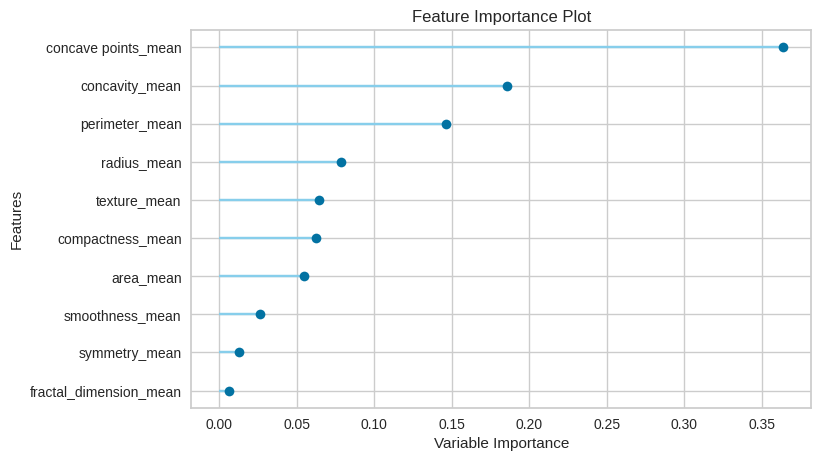

In [ ]:
plot_model(modelo_criado, plot='feature')

## Superfície de decisão

---
Em um problema de classificação estatística com duas classes, um limite de decisão ou superfície de decisão é uma hipersuperfície que divide o espaço vetorial subjacente em dois conjuntos, um para cada classe. O classificador classificará todos os pontos de um lado da fronteira de decisão como pertencentes a uma classe e todos os do outro lado como pertencentes à outra classe. Um limite de decisão é a região de um espaço de problema em que o rótulo de saída de um classificador é ambíguo.

(https://en.wikipedia.org/wiki/Decision_boundary#:~:text=In%20a%20statistical%2Dclassification%20problem,sets%2C%20one%20for%20each%20class.&text=A%20decision%20boundary%20is%20the,of%20a%20classifier%20is%20ambiguous.)


In [ ]:
plot_model(modelo_criado, plot='boundary')

## *Evaluate model*

---



Essa função nos permite escolher diversas outras métricas de validação do nosso modelo

In [ ]:
evaluate_model(modelo_criado)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Conclusão

---
Nosso modelo de classificação random forest obteve sucesso em **79,5%** dos dados de teste (20% dos dados totais).

A todo momento vem ocorrendo mudanças e avanços na utilização de técnicas de inteligência artificial, principalmente na área da saúde. Detecção de câncer por meio de algoritmos de Machine Learning tem ajudado cada vez mais os médicos a diagnosticarem seus pacientes, assim aumentando as chances dos tratamentos convencionais.

No entanto, mesmo a construção de modelos altamente confiáveis para a detecção de câncer de mama não substitui uma variável, a principal feature, o **diagnóstico precoce**.
